In [1]:
%load_ext autoreload
%autoreload 2

import torch

#from lib.model.progen.init_model import init_model
from lib.model.extended.init_model import init_model
from lib.model.train import train
from lib.model.progen.init_tokenizer import init_tokenizer
from lib.data.datasets.GB1 import get_GB1_dataset

s:\Documents\master\ProGen\progen\progen2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Tokenizer

In [3]:
tokenizer = init_tokenizer()
tokenize = lambda sequence: torch.tensor(tokenizer.encode(sequence).ids)

Model

In [ ]:
#model = init_model().to(device)
#model = init_model(state_dict_path="/models/progen_extended_data_balanced_01.pt").to(device)
model = init_model(state_dict_path="/models/progen_extended_v1.pt").to(device)
model.eval()


In [ ]:
print([param for param in model.parameters()])

In [8]:
max(abs(model.fitness_head.weight[0]))

tensor(0.1767, device='cuda:0', grad_fn=<UnbindBackward>)

In [ ]:
model

Trained model sandbox

In [46]:

import torch
from lib.model.extended.init_model import init_model
from lib.model.progen.init_tokenizer import init_tokenizer
from lib.data.datasets.GB1 import prepare_sequences, tokenize_batch, load_data

MODEL_NAME = "progen_extended_data_balanced_02"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = init_tokenizer()
tokenize = lambda sequence: torch.tensor(tokenizer.encode(sequence).ids)

info = torch.load("./models/" + MODEL_NAME + "_info.pt")
test_variants = info["test_variants"]
test_sequences = tokenize_batch(prepare_sequences(test_variants), tokenize).to(device)
df = load_data()

model = init_model(state_dict_path="/models/" + MODEL_NAME + ".pt").to(device)
model.eval()

s:\Documents\master\code\llm\lib\data\datasets\GB1.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized[s, :] = torch.tensor(tokenize(sequences[s]))
s:\Documents\master\ProGen\progen\progen2\.venv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
Some weights of the model checkpoint at s:\Documents\master\code\llm\lib\model\progen/../../../../../ProGen/progen/progen2/checkpoints/progen2-small were not used when initializing ProGenModel: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing ProGenModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing P

loading model state dict from file "s:\Documents\master\code\llm/models/progen_extended_data_balanced_02.pt"


TransformerExtended(
  (transformer): ProGenModel(
    (wte): Embedding(32, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): ProGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): ProGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (mlp): ProGenMLP(
          (fc_in): Linear(in_features=1024, out_features=4096, bias=True)
          (fc_out): Linear(in_features=4096, out_features=1024, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): ProGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): ProGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dro

In [47]:
test_labels = [df.loc[df["Variants"] == variant]["Fitness"].values[0] for variant in test_variants]
test_labels = torch.tensor(test_labels).to(device)

In [48]:
import numpy as np

test_df = df.loc[df["Variants"].isin(test_variants)]
best_test_variant = np.argmax(test_df["Fitness"].values)
best_test_variant

233

In [5]:
from lib.model.train import evaluation_step, get_batch_borders

test_batch_borders = get_batch_borders(len(test_sequences), 1)
loss = evaluation_step(
    model,
    device,
    test_sequences,
    test_labels,
    test_batch_borders,
    torch.nn.functional.l1_loss,
)
loss

mean test-data loss = 1.269073486328125


tensor(1.2691, device='cuda:0')

In [49]:
predictions = torch.empty(len(test_sequences))
for s in range(len(test_sequences)):
    predictions[s] = model(test_sequences[s])[-1]
pred = predictions.clone().detach().numpy()
print(max(pred))

-0.050973818


Text(0.5, 1.0, 'Fitness distribution')

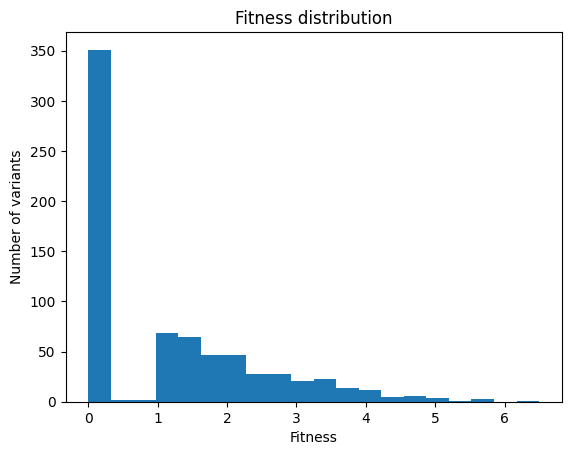

In [50]:
import matplotlib.pyplot as plt

test_fitness = test_df["Fitness"].values
n_bins = 20
plt.hist(test_fitness, n_bins)
plt.xlabel("Fitness")
plt.ylabel("Number of variants")
plt.title("Fitness distribution")

Text(0.5, 1.0, 'Fitness distribution')

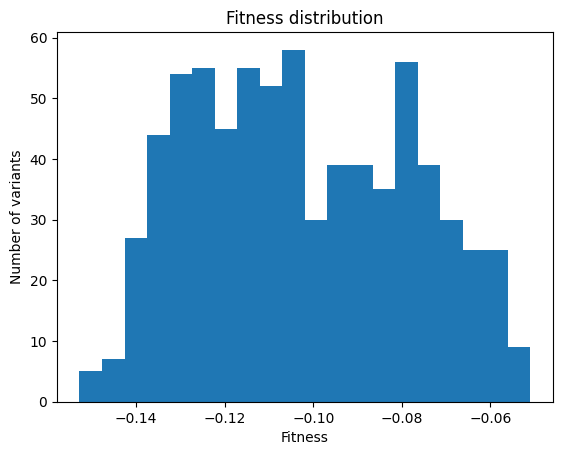

In [51]:
#test
n_bins = 20
plt.hist(pred, n_bins)
plt.xlabel("Fitness")
plt.ylabel("Number of variants")
plt.title("Fitness distribution")

Text(0.5, 1.0, 'Fitness distribution')

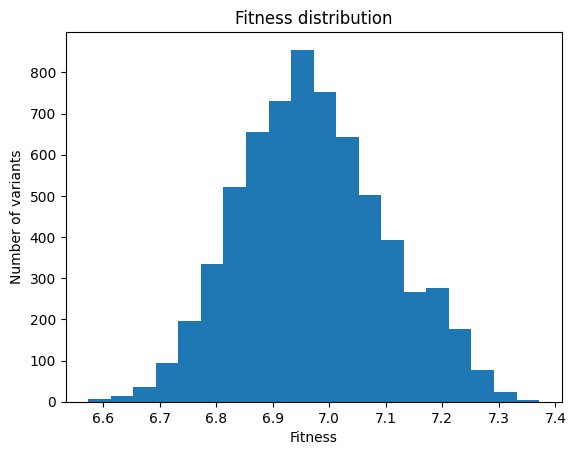

In [67]:
#train
n_bins = 20
plt.hist(pred, n_bins)
plt.xlabel("Fitness")
plt.ylabel("Number of variants")
plt.title("Fitness distribution")

In [42]:
sequence_id = best_test_variant

print(model(test_sequences[sequence_id])[-1])
print(df.loc[df["Variants"] == test_variants[sequence_id]]["Fitness"].values)

tensor([6.9362], device='cuda:0', grad_fn=<SelectBackward>)
[2.54879988]


In [64]:
train_variants = info["train_variants"]
train_sequences = tokenize_batch(prepare_sequences(train_variants), tokenize).to(device)

s:\Documents\master\code\llm\lib\data\datasets\GB1.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized[s, :] = torch.tensor(tokenize(sequences[s]))


In [65]:
train_predictions = torch.empty(len(train_sequences))
for s in range(len(train_sequences)):
    train_predictions[s] = model(train_sequences[s])[-1]

In [66]:
pred = train_predictions.clone().detach().numpy()

In [8]:
from lib.data.datasets.GB1 import prepare_sequences

#wt = 'MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE'
seq = prepare_sequences(['LNCA'])[0]
# FWAA
# LNCA
# QNLE

#out = model(tokenize(seq).to(device), output_hidden_states = True)
#logits = out.logits

out = model(tokenize(seq).to(device))
out

tensor([[-0.0297],
        [-0.0547],
        [-0.0572],
        [-0.0728],
        [-0.0763],
        [-0.0810],
        [-0.0774],
        [-0.0795],
        [-0.0846],
        [-0.0877],
        [-0.0871],
        [-0.0903],
        [-0.0942],
        [-0.0920],
        [-0.0917],
        [-0.0929],
        [-0.0952],
        [-0.0938],
        [-0.0978],
        [-0.0963],
        [-0.0982],
        [-0.0968],
        [-0.0966],
        [-0.0993],
        [-0.1003],
        [-0.0960],
        [-0.0958],
        [-0.0940],
        [-0.0992],
        [-0.0997],
        [-0.0983],
        [-0.0965],
        [-0.0987],
        [-0.1008],
        [-0.1014],
        [-0.0977],
        [-0.0956],
        [-0.0970],
        [-0.0996],
        [-0.0923],
        [-0.0957],
        [-0.0955],
        [-0.1003],
        [-0.0975],
        [-0.0936],
        [-0.0931],
        [-0.0968],
        [-0.0978],
        [-0.1008],
        [-0.0949],
        [-0.0901],
        [-0.0953],
        [-0.

In [ ]:
#seq = 100*"A"
seq = 100 * "C"
#seq = 99*"A" + "C"
#seq = "CCCC" + 96*"A"
#seq = "CCCC" + 31*"ACC" + "ACC"
print(len(seq))
print(seq.count('A'))

print(model(tokenize(seq).to(device)))

Save / Load model states

In [45]:
import os

In [50]:
MODEL_PATH = os.getcwd() + "/models/progen_extended_v1.pt"

In [24]:
#torch.save(model, MODEL_PATH)

torch.save(model.state_dict(), MODEL_PATH)

In [ ]:
#model = torch.load(MODEL_PATH)

# ! init the model first
model.load_state_dict(torch.load(MODEL_PATH))

Data

In [166]:
tokenize = lambda sequence: tokenizer.encode(sequence).ids

sequences, fitnesses = get_GB1_dataset(
    tokenize=tokenize,
    device=device,
    shuffle=False,
)

s:\Documents\master\ProGen\progen\progen2\.venv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [10]:
TEST_SPLIT = 500 / 149631

tokenize = lambda sequence: tokenizer.encode(sequence).ids

train_sequences, train_fitnesses, test_sequences, test_fitnesses = get_GB1_dataset(
    tokenize=tokenize,
    test_split=TEST_SPLIT,
    device=device,
)

s:\Documents\master\ProGen\progen\progen2\.venv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [13]:
N_DATA = 100

n_train = int(N_DATA * (1-TEST_SPLIT))
n_test = int(N_DATA * TEST_SPLIT)
train_sequences = train_sequences[0:n_train]
train_fitnesses = train_fitnesses[0:n_train]
test_sequences = test_sequences[0:n_test]
test_fitnesses = test_fitnesses[0:n_test]

In [ ]:
from lib.model.extended.init_model import init_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = init_model(state_dict_path="/models/progen_extended_data_filter_04.pt").to(device)
model.eval()

In [ ]:
fitnesses = torch.empty(len(sequences))
for s in range(len(sequences)):
    fitnesses[s] = model.forward(sequences[s])[-1]
fitnesses

In [169]:
decode = lambda id: tokenizer.id_to_token(id)


def extract_token(seq, idx, decode):
    return decode(int(seq[idx]))


seq = sequences[57022]
print(
    extract_token(seq, 38, decode)
    + extract_token(seq, 39, decode)
    + extract_token(seq, 40, decode)
    + extract_token(seq, 53, decode)
)

FWAA


In [201]:
# 127726; SQMA; 0,0140767875885
# 57022; FWAA; 8,76196565571
out = model.forward(sequences[127726])
out.size()
out[-1]

tensor([-0.0786], device='cuda:0', grad_fn=<SelectBackward>)

In [202]:
out = model.forward(sequences[57022])
out.size()
out[-1]

tensor([-0.0783], device='cuda:0', grad_fn=<SelectBackward>)

Train

In [ ]:
loss_history = train(
    model=model,
    device=device,

    train_data=train_sequences,
    train_labels=train_fitnesses,
    test_data=test_sequences,
    test_labels=test_fitnesses,

    loss_function=torch.nn.functional.mse_loss,
    batch_size=1,
    learning_rate=1e-3,
    n_epochs=1,
)

Train Progen Extended

In [1]:
%load_ext autoreload
%autoreload 2

from progen_extended import train_progen_extended

s:\Documents\master\ProGen\progen\progen2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
loss_history = train_progen_extended(
    state_dict_path="",
    save_state_dict="/models/progen_extended_tmp2.pt",
    save_history="/models/progen_extended_tmp2_history.pt",
)

Sandbox

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [33]:
loss_history = torch.load("./models/progen_extended_data_balanced_05_info.pt")["loss_history"]
#loss_history = torch.load("./models/progen_extended_v1_01_history.pt")
#loss_history = torch.load("./models/progen_extended_data_filter_09_history.pt")

In [35]:
tp = torch.load("./models/progen_extended_data_balanced_05_info.pt")
#tp = torch.load("./models/progen_extended_data_filter_06_train_params.pt")
tp

{'loss_function': <function torch.nn.functional.l1_loss(input: torch.Tensor, target: torch.Tensor, size_average: Union[bool, NoneType] = None, reduce: Union[bool, NoneType] = None, reduction: str = 'mean') -> torch.Tensor>,
 'learning_rate': 0.001,
 'batch_size': 1,
 'n_epochs': 1,
 'evaluation_period': 1000,
 'train_variants': array(['MRLG', 'VVAG', 'FIGM', ..., 'FWYG', 'WHGC', 'WCFA'], dtype=object),
 'test_variants': array(['VCFG', 'YRGA', 'IYCA', 'AYGV', 'IVYG', 'IDSA', 'VFGM', 'FRCC',
        'LNYG', 'FYGT', 'ECGC', 'LWMG', 'EMCA', 'MCAA', 'TQCA', 'VSCA',
        'IKGC', 'LVSA', 'IQAC', 'ICLT', 'IVGA', 'CYGM', 'MGCA', 'HIGT',
        'YYGC', 'LIGM', 'WQLG', 'FHGT', 'WIFG', 'LAMA', 'ARCG', 'QAGC',
        'LFCA', 'KDCA', 'WWCI', 'CSLG', 'APCA', 'VRAL', 'RHGM', 'WKLC',
        'IFGV', 'LRFG', 'TYGC', 'IDAA', 'HVFG', 'YRCG', 'IALG', 'WNLA',
        'KMCA', 'VSFG', 'WYGL', 'YYAA', 'WVCA', 'MSLG', 'VKAM', 'IAAL',
        'WFGC', 'WAMG', 'MTLG', 'WHFT', 'YYCA', 'KCGL', 'WVFA', 'LRCA',
 

In [36]:
loss_history.size()

torch.Size([2, 2])

In [37]:
loss_history[-1][-1]

tensor(2.8072)

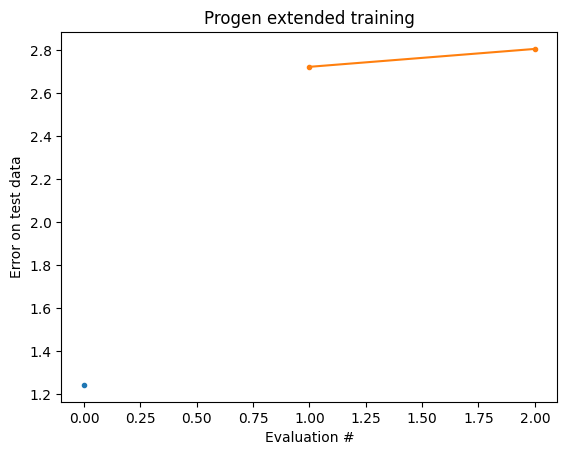

In [39]:
evaluation_period = 1
plt.plot(0, loss_history[0, -1], '.')
for i in range(1, loss_history.size()[0]):
    plt.plot(
        [evaluation_period*((i-1)*loss_history.size()[1]+b) for b in range(1, loss_history.size()[1]+1)],
        #torch.cat((loss_history[0, -1:], loss_history[1, :])),
        loss_history[i, :],
        ".-",
    )
plt.xlabel("Evaluation #")
#plt.xlabel("Batch number")
#plt.xticks(np.arange(0, 81, 5))
plt.ylabel("Error on test data")
#plt.ylabel("Mean L1 loss")
plt.title("Progen extended training")

plt.show()

In [ ]:
plt.plot(0, loss_history[0, -1], ".")
x = [0] + [b * 100 for b in range(1, loss_history.size()[1] + 1)]
y = torch.cat((loss_history[0, -1].view(1), loss_history[1, :]))
plt.plot(x, y, ".-")

plt.xlabel("Batch number")
plt.xticks(np.arange(min(x), 1001, 100))
plt.ylabel("Mean L1 evaluation loss")
#plt.title("Progen extended training")

plt.show()

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from progen_extended_init_test import test_initialization
from lib.utils.file import save_pt_file

s:\Documents\master\ProGen\progen\progen2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
N_INITIALIZATIONS = 100

DATA_INDEXES = [0, 1, 18, 74, 519, 623, 949, 32322, 50456, 49771]
N_DATA = None
#N_DATA = 100

LOSS_FUNCTION = torch.nn.functional.mse_loss
LOSS_FUNCTION_NAME = "mse"
RUN = 1

losses, sequences, fitnesses = test_initialization(
    n_initializations=N_INITIALIZATIONS,
    n_data=N_DATA,
    data_indexes=DATA_INDEXES,
    loss_function=LOSS_FUNCTION,
    return_data=True,
)

save_pt_file(
    {"losses": losses, "sequences": sequences, "fitnesses": fitnesses},
    #save_to=f"/data/init_test_ninit-{N_INITIALIZATIONS}_ndata-{N_DATA}_lf-{LOSS_FUNCTION_NAME}_run-{RUN}.pt",
    save_to=f"/data/init_test_ninit-{N_INITIALIZATIONS}_data-select_lf-{LOSS_FUNCTION_NAME}_run-{RUN}.pt",
    var_name="losses and data",
)

Connecting to device
Loading tokenizer
Loading GB1 data


s:\Documents\master\ProGen\progen\progen2\.venv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Initializing model


Some weights of the model checkpoint at s:\Documents\master\code\llm\lib\model\progen/../../../../../ProGen/progen/progen2/checkpoints/progen2-small were not used when initializing ProGenModel: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing ProGenModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ProGenModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Running initialization test


s:\Documents\master\code\llm\progen_extended_init_test.py:51: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 56, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  losses[init] = loss_function(outputs, fitnesses)


Initialization 1: loss = 3.0504567623138428
Initialization 2: loss = 8.231841087341309
Initialization 3: loss = 6.611791133880615
Initialization 4: loss = 3.734952449798584
Initialization 5: loss = 7.981017112731934
Initialization 6: loss = 8.263606071472168
Initialization 7: loss = 5.743655681610107
Initialization 8: loss = 3.9771087169647217
Initialization 9: loss = 3.639610767364502
Initialization 10: loss = 8.420339584350586
Initialization 11: loss = 8.270730972290039
Initialization 12: loss = 5.089890003204346
Initialization 13: loss = 4.61594295501709
Initialization 14: loss = 8.41986083984375
Initialization 15: loss = 7.164413928985596
Initialization 16: loss = 8.370397567749023
Initialization 17: loss = 8.238313674926758
Initialization 18: loss = 7.744263172149658
Initialization 19: loss = 3.364473342895508
Initialization 20: loss = 8.223790168762207
Initialization 21: loss = 5.46920108795166
Initialization 22: loss = 10.152097702026367
Initialization 23: loss = 7.8436217308044

In [4]:
fitnesses

tensor([1.0000, 0.0619, 2.4012, 3.8915, 0.0000, 5.0753, 0.6749, 2.0556, 3.6573,
        4.0796], device='cuda:0')

In [6]:
(
    sequences,
    fitnesses,
) = get_GB1_dataset(shuffle=False, raw=True)

s:\Documents\master\ProGen\progen\progen2\.venv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [71]:
sequence = 'AACAACAACAAACAACAACAAACAACAACAAACAACAACAAACAACAACAAACAACAACAAACAACAACAAACAACAACAAACAACAACAAACAACAACA'
#sequence = 'CCACCACCACCCACCACCACCCACCACCACCCACCACCACCCACCACCACCCACCACCACCCACCACCACCCACCACCACCCACCACCACCCACCACCAC'
sequence.count('A')

70

In [72]:
prediction = model(tokenize(sequence).to(device))

In [73]:
prediction

tensor([[ 83.6339],
        [ 83.6339],
        [ 97.4809],
        [100.6896],
        [ 88.4701],
        [ 87.8587],
        [ 85.4522],
        [ 72.6343],
        [ 84.1265],
        [ 79.6446],
        [ 58.5573],
        [ 78.8447],
        [ 92.9054],
        [ 79.2548],
        [ 79.8149],
        [ 80.9938],
        [ 80.0447],
        [ 64.2967],
        [ 79.4195],
        [ 80.0127],
        [ 64.9874],
        [ 76.4079],
        [ 86.0560],
        [ 80.3433],
        [ 62.1999],
        [ 79.2397],
        [ 80.3691],
        [ 62.5652],
        [ 79.0061],
        [ 79.3325],
        [ 62.2452],
        [ 69.8980],
        [ 84.3062],
        [ 77.7817],
        [ 61.2099],
        [ 76.6757],
        [ 79.0464],
        [ 61.9562],
        [ 76.4405],
        [ 77.5661],
        [ 62.6651],
        [ 64.0236],
        [ 82.6489],
        [ 76.2479],
        [ 59.7201],
        [ 75.7414],
        [ 77.9078],
        [ 61.8727],
        [ 75.0160],
        [ 76.1137],
